/tmp/ipykernel_51202/923394286.py:87: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")


Epoch 001 | Val MSE: 0.065468
Epoch 002 | Val MSE: 0.066358
Epoch 003 | Val MSE: 0.061136
Epoch 004 | Val MSE: 0.054322
Epoch 005 | Val MSE: 0.049653
Epoch 006 | Val MSE: 0.049116
Epoch 007 | Val MSE: 0.041750
Epoch 008 | Val MSE: 0.040140
Epoch 009 | Val MSE: 0.041011
Epoch 010 | Val MSE: 0.036211
Epoch 011 | Val MSE: 0.036631
Epoch 012 | Val MSE: 0.038308
Epoch 013 | Val MSE: 0.035697
Epoch 014 | Val MSE: 0.037786
Epoch 015 | Val MSE: 0.036753
Epoch 016 | Val MSE: 0.035673
Epoch 017 | Val MSE: 0.037946
Epoch 018 | Val MSE: 0.039838
Epoch 019 | Val MSE: 0.034080
Epoch 020 | Val MSE: 0.038692
Epoch 021 | Val MSE: 0.034255
Epoch 022 | Val MSE: 0.034768
Epoch 023 | Val MSE: 0.036606
Epoch 024 | Val MSE: 0.034402
Epoch 025 | Val MSE: 0.033673
Epoch 026 | Val MSE: 0.033099
Epoch 027 | Val MSE: 0.036671
Epoch 028 | Val MSE: 0.032330
Epoch 029 | Val MSE: 0.034920
Epoch 030 | Val MSE: 0.036470
Epoch 031 | Val MSE: 0.037318
Epoch 032 | Val MSE: 0.034921
Epoch 033 | Val MSE: 0.036947
Epoch 034 

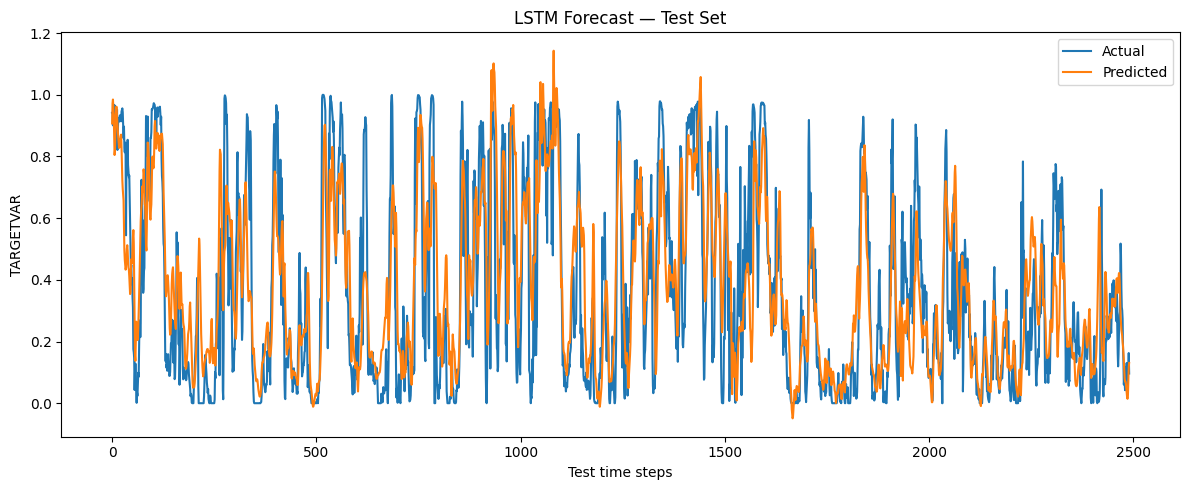

In [1]:
# train_lstm_wind.py
# pip install torch pandas scikit-learn joblib matplotlib

import math
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# ========= CONFIG =========
FILE_PATH       = "WindPowerForecastingData.xlsx"   # <-- put your path here
SHEET_NAME      = "WindPowerForecastingData"

TIME_COL        = "TIMESTAMP"
TARGET_COL      = "TARGETVAR"
FEATURE_COLS    = ["U10", "V10", "U100", "V100"]

LOOKBACK        = 24       # hours to look back
TRAIN_RATIO     = 0.70
VAL_RATIO       = 0.15     # TEST = 1 - TRAIN - VAL

BATCH_SIZE      = 128
HIDDEN_SIZE     = 128
NUM_LAYERS      = 2
DROPOUT         = 0.2
LR              = 1e-3
MAX_EPOCHS      = 100
PATIENCE        = 15

SAVE_DIR        = Path(".")
SAVE_MODEL_PATH = SAVE_DIR / "lstm_wind_best.pt"
SAVE_XS_PATH    = SAVE_DIR / "feature_scaler.pkl"
SAVE_YS_PATH    = SAVE_DIR / "target_scaler.pkl"
SAVE_PLOT_PATH  = SAVE_DIR / "test_plot.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= DATA UTILS =========
def make_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i, :])
        y_seq.append(y[i, 0])  # one-step-ahead
    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32).reshape(-1, 1)
    return X_seq, y_seq

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ========= MODEL =========
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)      # (B, T, H)
        last = out[:, -1, :]       # (B, H)
        return self.fc(last)       # (B, 1)

# ========= TRAIN / EVAL =========
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def main():
    # Load
    df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    data = df[[TIME_COL, TARGET_COL] + FEATURE_COLS].dropna().reset_index(drop=True)

    # Chrono split
    n = len(data)
    n_train = int(n * TRAIN_RATIO)
    n_val   = int(n * (TRAIN_RATIO + VAL_RATIO))

    train_df = data.iloc[:n_train].reset_index(drop=True)
    val_df   = data.iloc[n_train:n_val].reset_index(drop=True)
    test_df  = data.iloc[n_val:].reset_index(drop=True)

    # Scale (fit on train)
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train = x_scaler.fit_transform(train_df[FEATURE_COLS].values.astype(np.float32))
    y_train = y_scaler.fit_transform(train_df[[TARGET_COL]].values.astype(np.float32))
    X_val   = x_scaler.transform(val_df[FEATURE_COLS].values.astype(np.float32))
    y_val   = y_scaler.transform(val_df[[TARGET_COL]].values.astype(np.float32))
    X_test  = x_scaler.transform(test_df[FEATURE_COLS].values.astype(np.float32))
    y_test  = y_scaler.transform(test_df[[TARGET_COL]].values.astype(np.float32))

    # Sequences
    Xtr_seq, ytr_seq = make_sequences(X_train, y_train, LOOKBACK)
    Xv_seq,  yv_seq  = make_sequences(X_val,   y_val,   LOOKBACK)
    Xte_seq, yte_seq = make_sequences(X_test,  y_test,  LOOKBACK)

    train_loader = DataLoader(SeqDS(Xtr_seq, ytr_seq), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(SeqDS(Xv_seq,  yv_seq ), batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(SeqDS(Xte_seq, yte_seq), batch_size=BATCH_SIZE, shuffle=False)

    # Model
    model = LSTMRegressor(len(FEATURE_COLS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # Early stopping
    best_val = float("inf"); no_improve = 0
    for epoch in range(1, MAX_EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(criterion(model(xb), yb).item())
        val_mse = float(np.mean(val_losses))
        print(f"Epoch {epoch:03d} | Val MSE: {val_mse:.6f}")

        if val_mse < best_val - 1e-6:
            best_val = val_mse; no_improve = 0
            torch.save(model.state_dict(), SAVE_MODEL_PATH)
            joblib.dump(x_scaler, SAVE_XS_PATH)
            joblib.dump(y_scaler, SAVE_YS_PATH)
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch} (best Val MSE={best_val:.6f}).")
                break

    # Load best, evaluate on TEST (inverse-scaled)
    model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))
    model.eval()

    y_true_s, y_pred_s = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb.to(device)).cpu().numpy()
            y_pred_s.append(preds)
            y_true_s.append(yb.numpy())

    y_pred_s = np.vstack(y_pred_s)
    y_true_s = np.vstack(y_true_s)

    y_pred = y_scaler.inverse_transform(y_pred_s).ravel()
    y_true = y_scaler.inverse_transform(y_true_s).ravel()

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smp  = smape(y_true, y_pred)

    print("\n=== TEST METRICS (original units) ===")
    print(f"RMSE : {rmse:.6f}")
    print(f"MAE  : {mae:.6f}")
    print(f"R^2  : {r2:.6f}")
    print(f"sMAPE: {smp:.2f}%")

    # Plot & save
    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title("LSTM Forecast — Test Set")
    plt.xlabel("Test time steps")
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.tight_layout()
    plt.savefig(SAVE_PLOT_PATH, dpi=150)
    print(f"\nSaved: {SAVE_MODEL_PATH}, {SAVE_XS_PATH}, {SAVE_YS_PATH}, {SAVE_PLOT_PATH}")

# ========= INFERENCE ON A NEW FILE =========
def predict_on_new_dataframe(df_new: pd.DataFrame) -> np.ndarray:
    """
    df_new must contain FEATURE_COLS with same units/scales used during training.
    Returns predictions (original target units) starting from index LOOKBACK.
    """
    x_scaler = joblib.load(SAVE_XS_PATH)
    y_scaler = joblib.load(SAVE_YS_PATH)
    model = LSTMRegressor(len(FEATURE_COLS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))
    model.eval()

    X_new = x_scaler.transform(df_new[FEATURE_COLS].values.astype(np.float32))

    # build sequences (dummy y)
    X_seq = []
    for i in range(LOOKBACK, len(X_new)):
        X_seq.append(X_new[i-LOOKBACK:i, :])
    X_seq = np.array(X_seq, dtype=np.float32)
    dl = DataLoader(SeqDS(X_seq, np.zeros((len(X_seq),1), dtype=np.float32)), batch_size=BATCH_SIZE, shuffle=False)

    preds_s = []
    with torch.no_grad():
        for xb, _ in dl:
            p = model(xb.to(device)).cpu().numpy()
            preds_s.append(p)
    preds_s = np.vstack(preds_s)
    preds = y_scaler.inverse_transform(preds_s).ravel()
    return preds

if __name__ == "__main__":
    main()
